In [44]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
from torchvision.models import resnet18,ResNet18_Weights
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
from tqdm import tqdm

from IPython.display import display
from IPython.display import Image as Img

In [23]:
## setting random seed
_=torch.manual_seed(42)

### Loading the EUROSAT Dataset --> Applying Transforms --> Creating the DataLoader

In [24]:
train_transforms=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomRotation(degrees=20),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485,0.456,0.406],
        std=[0.229,0.224,0.225])
    ])

val_transforms=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485,0.456,0.406],
        std=[0.229,0.224,0.225] 
    )])

eurosat_dataset=datasets.EuroSAT(root="/Users/praroopchanda/Desktop/Eurosat_Classification_Project/",download=True)

print(f"The length of Total EuroSat Dataset is: {len(eurosat_dataset)}")

## 70% train and 30% validation split
train_size=int(0.7*len(eurosat_dataset))
val_size=int(0.15* len(eurosat_dataset))
test_size=len(eurosat_dataset) -train_size -val_size

print(f"length of training_dataset is:{train_size}")
print(f"length of validation set is: {val_size}")
print(f"length of test dataset: {test_size}")

train_dataset, val_dataset,test_dataset=random_split(eurosat_dataset,[train_size,val_size,test_size])

## applying transforms
train_dataset.dataset.transform=train_transforms
val_dataset.dataset.transform=val_transforms
test_dataset.dataset.transform=val_transforms

## dataloader
train_loader=DataLoader(train_dataset,batch_size=32,shuffle=True,num_workers=4)
val_loader=DataLoader(val_dataset,batch_size=32,shuffle=False,num_workers=4)
test_loader=DataLoader(test_dataset,batch_size=32,shuffle=False,num_workers=4)

#device --> use gpu if a CUDA enabled device
device=torch.device("mps" if torch.backends.mps.is_available() else "cpu")


The length of Total EuroSat Dataset is: 27000
length of training_dataset is:18900
length of validation set is: 4050
length of test dataset: 4050


In [42]:
print(f"The classes in the dataset are:",eurosat_dataset.classes)

The classes in the dataset are: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


# Defining the Model

## Model Ideation

We use a **ResNet-18** pretrained with ImageNet weights as a backbone, for classification \
Instead of its original fully connected layer for 1000 ImageNet classes, we add a small custom head for our classification task 

Details of our custom head: -- \
** we first take the input 512 feature vector (also the output of average pooling) as input to our custom head \
** we project this 512 feature vectors to 256 dim via a fully connected layer \
** ReLU activation for non-linearity followed by dropout for better generalization is added \
** Final fully connected layer converts this 256 dim feature vector to **10 dim** feature vector (same number as our output classes)

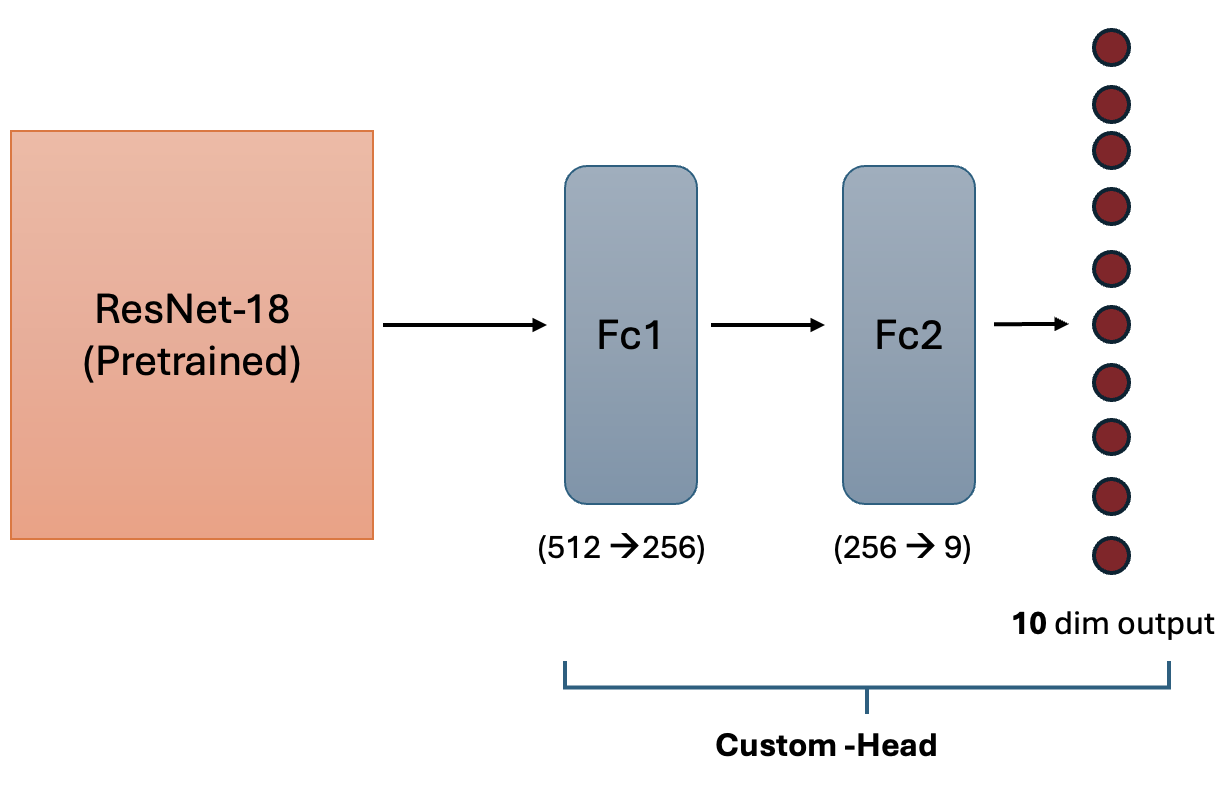

In [46]:
display(Img(filename="/Users/praroopchanda/Desktop/Eurosat_Classification_Project/Resnet_18_custom_head.png", width=500, height=350))

## Model Implementation and Technical Specifications
** We freeze layers 1-3 for Resnet and only layer 4 **(containing the last 4 Convolution layers)** + custom head is trainable \
** Total number of trainable parameters **~8.5M** \
** We train our model for 10 epochs
** Loss used is **CrossEntropy**  \
** We use AdamW optimizer for weight updates 

**** Resnet-18 model ****


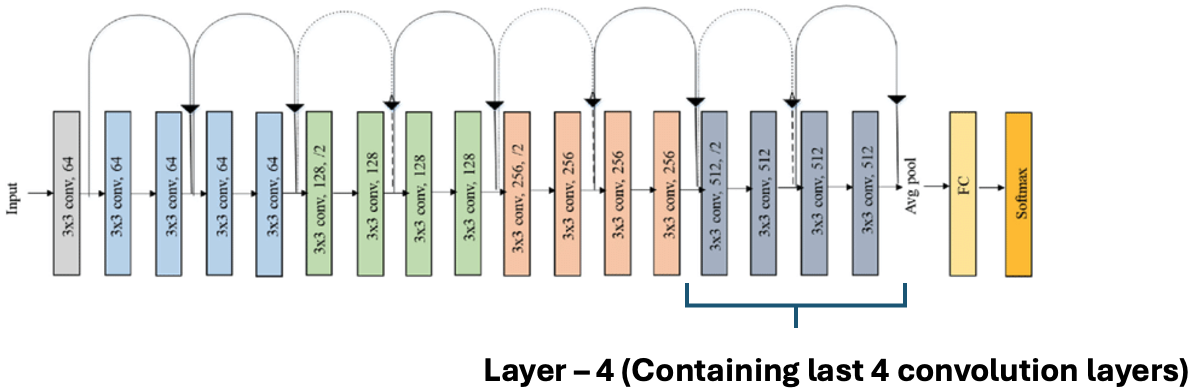

** ------- Final Training Pipeline ---------- **


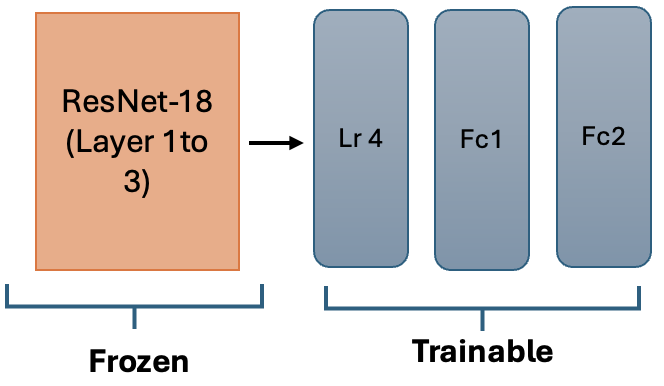

In [49]:
print ("**** Resnet-18 model ****")
display(Img(filename="/Users/praroopchanda/Desktop/Eurosat_Classification_Project/Resnet.png", width=400, height=250))

print ("** ------- Final Training Pipeline ---------- **")
display(Img(filename="/Users/praroopchanda/Desktop/Eurosat_Classification_Project/Train_Pipeline_1.png", width=400, height=250))

In [25]:
class MultiClassSingleLabelModel(nn.Module):
    def __init__(self):
        super().__init__()
        backbone=resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        input_dim=backbone.fc.in_features # input features of the last fully connected layer of resnet which is 512
        backbone.fc=nn.Identity() # basically same feature input 512 dimensions is passed as an output instead of the 1000 (used for ImageNet classes)
        self.backbone=backbone
        self.head=nn.Sequential( ## new head for multi -label classification
            nn.Linear(input_dim,256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),  # improve generalization
            nn.Linear(256,10) # 10 is length of classes
        )

    def forward(self,x):
        feature=self.backbone(x)
        return self.head(feature)    

In [26]:
### Initializing the model loss and optimizer ###
model=MultiClassSingleLabelModel().to(device)

## freezing conv1+ layer1 + layer 2 + layer 3 for resnet
for p in model.backbone.parameters():
    p.requires_grad=False
head_param_count=sum(x.numel() for x in model.parameters() if x.requires_grad) # counting custom head params
for p in model.backbone.layer4.parameters():
    p.requires_grad=True
#----- At this point layer 4 (resnet) + custom head is trainable ---- ## 

train_params=[x for x in model.parameters() if x.requires_grad]
trainable_count=sum(x.numel() for x in model.parameters() if x.requires_grad) # counting total trainable params
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.AdamW(train_params,lr=3e-4,weight_decay=1e-3)

print("Total number of Trainable parameters are:",trainable_count)

Total number of Trainable parameters are: 8527626


### Hyperparameter Tuning  --> Using validation set

In [27]:
### Training loop for Hyperparameter tuning ##
def train(train_Loader:DataLoader,val_loader:DataLoader,model:nn.Module,train_params,epochs=3,lr=3e-4):
    criterion=nn.CrossEntropyLoss()
    optimizer=torch.optim.AdamW(train_params,lr=lr,weight_decay=1e-3)    
    total_epochs=epochs
    model_checkpoint_path=f"/Users/praroopchanda/Desktop/Eurosat_Classification_Project/model_checkpoint_{lr}.pkt" ## path for saving checkpoint
    train_losses=[] # will be using these for plotting
    val_losses=[]

    print("Started Training")
    for epoch in range(total_epochs):
        loss_per_epoch=0
        model.train()

        data_iterator=tqdm(train_loader,desc=f'Epoch {epoch+1}')
        for image, label in data_iterator:
            image,label=image.to(device),label.to(device) # moving to mps backend
            optimizer.zero_grad() # clearing out all gradients
            prd_class=model(image)
            loss=criterion(prd_class,label)

            loss.backward()
            optimizer.step()

            loss_per_epoch+=loss.item()
        avg_loss=loss_per_epoch/len(data_iterator)
        train_losses.append(avg_loss)

        print(f"Epoch:{epoch+1} Avg Training Loss: {avg_loss:.6f}")
        ## validating after each epoch
        model.eval()
        val_loss=0
        with torch.no_grad():
            for image,label in val_loader:
                image,label=image.to(device),label.to(device)
                prd_class=model(image)
                loss=criterion(prd_class,label)
                val_loss+=loss
        avg_val_loss=val_loss/len(val_loader)
        print(f"Epoch:{epoch+1} Validation Loss:{avg_val_loss:.6f}")
        val_losses.append(avg_val_loss.detach().cpu().item())

    ## Plotting training and validation losses
    fig, axs = plt.subplots(1, 2, figsize=(7, 3))  # 1 row, 2 columns

    # Train Loss 
    axs[0].plot(range(total_epochs), train_losses, label='Train Loss', color='blue', marker='o')
    axs[0].set_title(f'Training Loss per Epoch with lr:{lr}')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].grid(True)

    # Validation Loss
    axs[1].plot(range(total_epochs), val_losses, label='Val Loss', color='red', marker='o')
    axs[1].set_title(f'Validation Loss per Epoch with lr:{lr}')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Loss')
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()    

    ## saving the model for testing submission 
    torch.save(model.state_dict(),model_checkpoint_path)
    print(f"Training done and model saved for lr: {lr}")


--------- Training for Lr ------->:0.001
Started Training


Epoch 1: 100%|██████████| 591/591 [01:48<00:00,  5.43it/s]

Epoch:1 Avg Training Loss: 0.337037


Epoch:1 Validation Loss:0.121930


Epoch 2: 100%|██████████| 591/591 [01:45<00:00,  5.59it/s]

Epoch:2 Avg Training Loss: 0.190577


Epoch:2 Validation Loss:0.125314


Epoch 3: 100%|██████████| 591/591 [01:47<00:00,  5.47it/s]

Epoch:3 Avg Training Loss: 0.152322


Epoch:3 Validation Loss:0.099132


Epoch 4: 100%|██████████| 591/591 [01:46<00:00,  5.57it/s]

Epoch:4 Avg Training Loss: 0.124253


Epoch:4 Validation Loss:0.082448


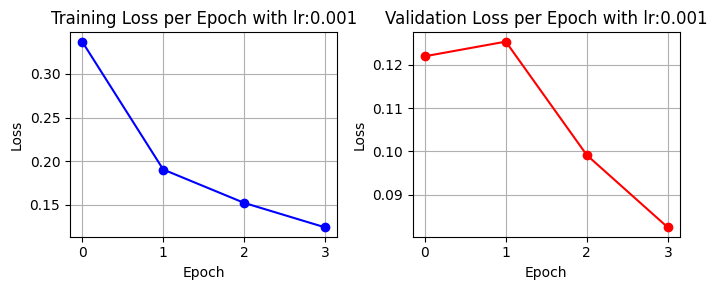

Training done and model saved for lr: 0.001
--------- Training for Lr ------->:0.0004
Started Training


Epoch 1: 100%|██████████| 591/591 [01:46<00:00,  5.57it/s]

Epoch:1 Avg Training Loss: 0.301867


Epoch:1 Validation Loss:0.136347


Epoch 2: 100%|██████████| 591/591 [01:47<00:00,  5.51it/s]

Epoch:2 Avg Training Loss: 0.140111


Epoch:2 Validation Loss:0.117813


Epoch 3: 100%|██████████| 591/591 [02:00<00:00,  4.92it/s]

Epoch:3 Avg Training Loss: 0.102883


Epoch:3 Validation Loss:0.103608


Epoch 4: 100%|██████████| 591/591 [02:17<00:00,  4.30it/s]

Epoch:4 Avg Training Loss: 0.079992


Epoch:4 Validation Loss:0.100190


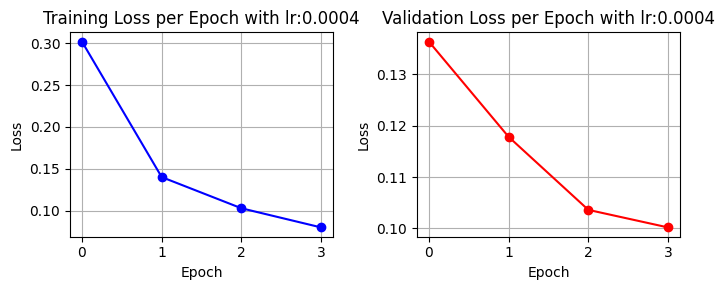

Training done and model saved for lr: 0.0004
--------- Training for Lr ------->:0.0001
Started Training


Epoch 1: 100%|██████████| 591/591 [01:49<00:00,  5.38it/s]

Epoch:1 Avg Training Loss: 0.347603


Epoch:1 Validation Loss:0.080062


Epoch 2: 100%|██████████| 591/591 [02:45<00:00,  3.57it/s]

Epoch:2 Avg Training Loss: 0.112107


Epoch:2 Validation Loss:0.076895


Epoch 3: 100%|██████████| 591/591 [02:30<00:00,  3.93it/s]

Epoch:3 Avg Training Loss: 0.066321


Epoch:3 Validation Loss:0.068929


Epoch 4: 100%|██████████| 591/591 [02:33<00:00,  3.86it/s]

Epoch:4 Avg Training Loss: 0.046813


Epoch:4 Validation Loss:0.085967


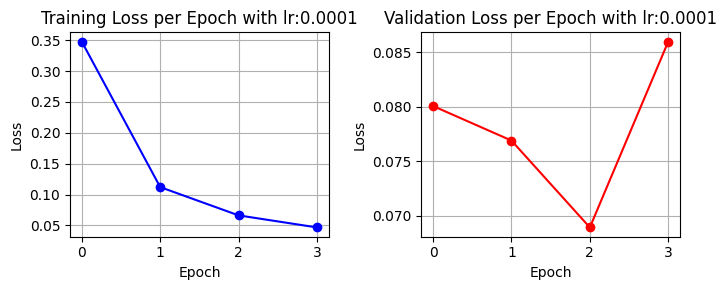

Training done and model saved for lr: 0.0001
--------- Training for Lr ------->:1e-05
Started Training


Epoch 1: 100%|██████████| 591/591 [01:47<00:00,  5.52it/s]

Epoch:1 Avg Training Loss: 1.208750


Epoch:1 Validation Loss:0.397936


Epoch 2: 100%|██████████| 591/591 [01:49<00:00,  5.39it/s]

Epoch:2 Avg Training Loss: 0.385354


Epoch:2 Validation Loss:0.175174


Epoch 3: 100%|██████████| 591/591 [01:56<00:00,  5.06it/s]

Epoch:3 Avg Training Loss: 0.245907


Epoch:3 Validation Loss:0.125963


Epoch 4: 100%|██████████| 591/591 [01:51<00:00,  5.32it/s]

Epoch:4 Avg Training Loss: 0.191253


Epoch:4 Validation Loss:0.109785


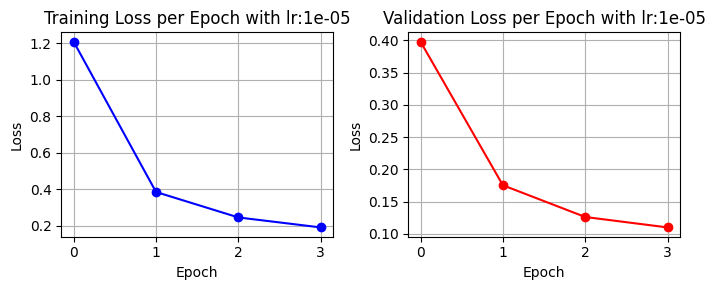

Training done and model saved for lr: 1e-05


In [28]:
### Tuning the learning Rate
learning_rates=[1e-3,4e-4,1e-4,1e-5]
for lr in learning_rates:
    print(f"--------- Training for Lr ------->:{lr}")
    model=MultiClassSingleLabelModel().to(device)
    ## freezing conv1+ layer1 + layer 2 + layer 3 for resnet
    for p in model.backbone.parameters():
        p.requires_grad=False
    head_param_count=sum(x.numel() for x in model.parameters() if x.requires_grad) # counting custom head params
    for p in model.backbone.layer4.parameters():
        p.requires_grad=True
    #----- At this point layer 4 (resnet) + custom head is trainable ---- ## 

    train_params=[x for x in model.parameters() if x.requires_grad]
    trainable_count=sum(x.numel() for x in model.parameters() if x.requires_grad) # counting total trainable params

    train(train_loader,val_loader,model,train_params=train_params,epochs=4,lr=lr)


### Amongst all the learning rates experimented, model trained with lr=1e-5, exhibits a validation loss curve That closely matches with the training loss curve and hence we use to train our model.

--------- Final Training for 10 epochs with Lr ------->:1e-05
Started Training


Epoch 1: 100%|██████████| 591/591 [01:47<00:00,  5.48it/s]

Epoch:1 Avg Training Loss: 1.166100


Epoch:1 Validation Loss:0.396188


Epoch 2: 100%|██████████| 591/591 [01:47<00:00,  5.50it/s]

Epoch:2 Avg Training Loss: 0.380100


Epoch:2 Validation Loss:0.179247


Epoch 3: 100%|██████████| 591/591 [01:47<00:00,  5.51it/s]

Epoch:3 Avg Training Loss: 0.248552


Epoch:3 Validation Loss:0.130505


Epoch 4: 100%|██████████| 591/591 [01:47<00:00,  5.52it/s]

Epoch:4 Avg Training Loss: 0.190207


Epoch:4 Validation Loss:0.106610


Epoch 5: 100%|██████████| 591/591 [01:47<00:00,  5.51it/s]

Epoch:5 Avg Training Loss: 0.154227


Epoch:5 Validation Loss:0.092654


Epoch 6: 100%|██████████| 591/591 [01:56<00:00,  5.07it/s]

Epoch:6 Avg Training Loss: 0.126057


Epoch:6 Validation Loss:0.082350


Epoch 7: 100%|██████████| 591/591 [02:06<00:00,  4.68it/s]

Epoch:7 Avg Training Loss: 0.108294


Epoch:7 Validation Loss:0.075282


Epoch 8: 100%|██████████| 591/591 [02:32<00:00,  3.89it/s]

Epoch:8 Avg Training Loss: 0.087283


Epoch:8 Validation Loss:0.077225


Epoch 9: 100%|██████████| 591/591 [01:51<00:00,  5.30it/s]

Epoch:9 Avg Training Loss: 0.070506


Epoch:9 Validation Loss:0.076669


Epoch 10: 100%|██████████| 591/591 [01:54<00:00,  5.14it/s]

Epoch:10 Avg Training Loss: 0.061394


Epoch:10 Validation Loss:0.065805


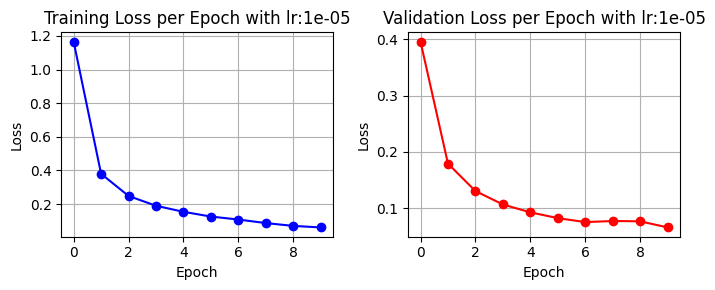

Training done and model saved for lr: 1e-05


In [ ]:
#### Infering from the above --> we choose lr=1e-5 for final training (10 epochs) and testing
lr=1e-5
print(f"--------- Final Training for 10 epochs with Lr ------->:{lr}")
model=MultiClassSingleLabelModel().to(device)
## freezing conv1+ layer1 + layer 2 + layer 3 for resnet
for p in model.backbone.parameters():
    p.requires_grad=False
head_param_count=sum(x.numel() for x in model.parameters() if x.requires_grad) # counting custom head params
for p in model.backbone.layer4.parameters():
    p.requires_grad=True
#----- At this point layer 4 (resnet) + custom head is trainable ---- ## 
train_params=[x for x in model.parameters() if x.requires_grad]
trainable_count=sum(x.numel() for x in model.parameters() if x.requires_grad) # counting total trainable params

train(train_loader,val_loader,model,train_params=train_params,epochs=10,lr=lr)

In [33]:
### Testing the model
## Initialing the model and loading the weights from final trained checkpoint
final_model=MultiClassSingleLabelModel()
final_model.load_state_dict(torch.load("/Users/praroopchanda/Desktop/Eurosat_Classification_Project/Final_ckpt_1e-5.pkt"))
final_model.to(device)
final_model.eval()
criterion=nn.CrossEntropyLoss()
test_loss=0
correct = 0
total = 0


with torch.no_grad():
    for images, labels in test_loader:
        images,labels=images.to(device),labels.to(device)
        prd_class=final_model(images)
     
        loss=criterion(prd_class,labels)
        test_loss+=loss.item()

        _, predicted = torch.max(prd_class.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()   

avg_test_loss=test_loss/len(test_loader)
accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")
print(f"Final Testing Loss: {avg_test_loss:.6f}")


/var/folders/_v/f2_06zts59b8mkw32cb3vcrw0000gn/T/ipykernel_7138/2029247687.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  final_model.load_state_dict(torch.load("/Users

Test Accuracy: 97.28%
Final Testing Loss: 0.081163


### Finally Calculating loss, Accuracy, Precision, Recall, F1 Score and Confusion Matrix for Test Set

In [38]:
def evaluation(model, test_loader, class_names=None):
    model.eval()
    all_preds = []
    all_labels = []
    test_loss=0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            prd_class = model(images)

            loss=criterion(prd_class,labels)
            test_loss+=loss.item()

            preds = torch.argmax(prd_class, dim=1)
            all_preds.extend(preds.cpu().numpy()) ## adding all predictions into array
            all_labels.extend(labels.cpu().numpy())

    avg_test_loss=test_loss/len(test_loader)
    # numpy conversion
    y_true = np.array(all_labels)
    y_pred = np.array(all_preds)

    # Accuracy
    accuracy = accuracy_score(y_true, y_pred)

    # Precision, Recall, F1 (using macro which is ==> average over classes)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average='macro', zero_division=0)

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    print("------ Evaluation Metrics -------")
    print(f"Loss on Test Set: {avg_test_loss:.4f}")
    print(f"Accuracy on Test Set : {accuracy:.4f}")
    print(f"Precision on Test Set: {precision:.4f}")
    print(f"Recall on Test Set  : {recall:.4f}")
    print(f"F1-score on Test Set : {f1:.4f}")

    plt.figure(figsize=(10, 8))
    disp.plot(cmap="Blues", xticks_rotation='vertical')
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

    return accuracy, precision, recall, f1


/var/folders/_v/f2_06zts59b8mkw32cb3vcrw0000gn/T/ipykernel_7138/3475919813.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  final_model.load_state_dict(torch.load("/Users

------ Evaluation Metrics -------
Loss on Test Set: 0.0812
Accuracy on Test Set : 0.9728
Precision on Test Set: 0.9715
Recall on Test Set  : 0.9725
F1-score on Test Set : 0.9719


<Figure size 1000x800 with 0 Axes>

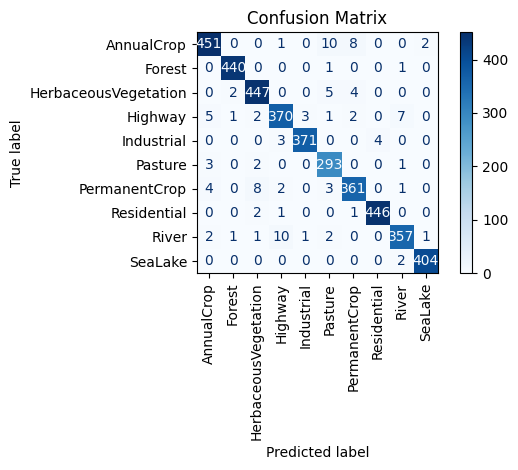

(0.9728395061728395,
 0.9715306508070565,
 0.9725363871444006,
 0.9719489698774278)

In [39]:
final_model=MultiClassSingleLabelModel()
final_model.load_state_dict(torch.load("/Users/praroopchanda/Desktop/Eurosat_Classification_Project/Final_ckpt_1e-5.pkt"))
final_model.to(device)
class_names=['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
evaluation(final_model,test_loader,class_names=class_names)